In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_plot_utils as apu
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import cmasher as cmm
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import plotly.express as px
import scipy
from epics import ca
from IPython.display import Image, display_png
from matplotlib import gridspec

ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
%matplotlib inline

In [4]:
mpl.rcParams.update({"font.size": 12, "text.usetex": False, "svg.fonttype": "none"})

In [5]:
exp_type = "peak_fwhm"

In [6]:
# base_dir = Path(aps.__file__).parents[1]
# autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type
print(f"data base dir exists {data_base_dir.exists()}")

data base dir exists True


## peak_fwhm_ref_150_2022-11-20

In [7]:
!ls $data_base_dir

Screen Shot 2022-11-20 at 10.35.04 AM.png
peak_fwhm_150_2022-11-18_images
peak_fwhm_150_2022-11-18_steps
peak_fwhm_autofocusing.ini
peak_fwhm_optimization_final_150_2022-11-18_16:24.pkl
peak_fwhm_ref_150_2022-11-18_images
peak_fwhm_ref_150_2022-11-18_steps
peak_fwhm_ref_150_2022-11-20_images
peak_fwhm_ref_150_2022-11-20_steps
peak_fwhm_ref_autofocusing.ini
peak_fwhm_ref_autofocusing_2022-11-18.ini
peak_fwhm_ref_autofocusing_2022-11-20.ini
peak_fwhm_ref_optimization_final_150_2022-11-18_01:23.pkl
peak_fwhm_ref_optimization_final_150_2022-11-20_14:09.gz
preliminary


In [8]:
log_file = Path(data_base_dir / "peak_fwhm_ref_optimization_final_150_2022-11-20_14:09.gz")
log_file.exists()

True

In [9]:
hist_dir = Path(data_base_dir / "peak_fwhm_ref_150_2022-11-20_steps")
hist_dir.exists()

True

In [10]:
base_out_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm")
base_out_dir.mkdir(exist_ok=True)

In [11]:
out_dir = base_out_dir / "ref_new"
out_dir.mkdir(exist_ok=True)

In [12]:
!cat $data_base_dir/peak_fwhm_ref_autofocusing_2022-11-20.ini

[Motor-Ranges]
hkb-bender-1 = -30.0, 30.0
hkb-bender-2 = -20.0, 30.0
hkb-pitch = -0.002, 0.002
hkb-translation = -0.03, 0.03
vkb-bender = -40.0, 40.0
vkb-pitch = -0.002, 0.002
vkb-translation = -0.03, 0.03
hkb-bender-threshold = 0.2
hkb-bender-n-threshold-checks = 3

[Motor-Boundaries]
boundaries-hkb-bender-1 = -200.0, -50.0
boundaries-hkb-bender-2 = -175.0, -50.0
boundaries-hkb-pitch = 0.168, 0.174
boundaries-hkb-translation = -0.5, 0.5
boundaries-vkb-bender = 0.0, 600.0
boundaries-vkb-pitch = 0.168, 0.174
boundaries-vkb-translation = -0.5, 0.5

[Optimization-Parameters]
sum-intensity-soft-constraint = 7000.0
sum-intensity-hard-constraint = 6500.0
centroid-sigma-threshold-dependency = 1
centroid-sigma-hard-thresholds-tuple = 0.01, 0.03
n-pitch-trans-motor-trials = 50
n-all-motor-trials = 100
loss-parameters = peak_distance, fwhm
log-parameters-weight = 0.25
reference-position = 0.0, 0.0
reference-size = 0.018, 0.007
moo-thresholds = 
moo-thresholds-position = 0.05
moo-thresholds-size 

In [13]:
study = analysis.create_study_from_trials(log_file, n_objectives=2)

[I 2023-07-03 10:55:48,422] A new study created in memory with name: no-name-4df7b700-395b-4a50-81ac-4984cea28271


Assuming minimization for all objectives.


In [14]:
n_steps = len(study.trials)

In [15]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension="gz")

In [16]:
len(hists), n_steps

(151, 151)

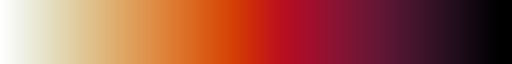

In [17]:
m2 = apu.CMAP
m2

In [18]:
reference = joblib.load("reference_peak_fwhm.joblib")
ref_hist = reference["hist"]
ref_dw = reference["dw"]

In [19]:
max_count = np.max([h.data_2D for h in hists])

In [20]:
2**16

65536

In [21]:
max_count, ref_hist.data_2D.max()

(65535.0, 65535.0)

Trial values: peak_distance 8.073e-02 fwhm 2.061e-02 
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3906470155167682, 'h_fwhm': 0.03771746178786728, 'h_centroid': -0.004864066210659962, 'h_peak': -0.07315886984715148, 'v_sigma': 0.4578418393986282, 'v_fwhm': 0.013005080109418365, 'v_centroid': 0.008027281339293701, 'v_peak': -0.03413833528722164, 'integral_intensity': 284.89001644793234, 'peak_intensity': 44962.0, 'gaussian_fit': {}}}


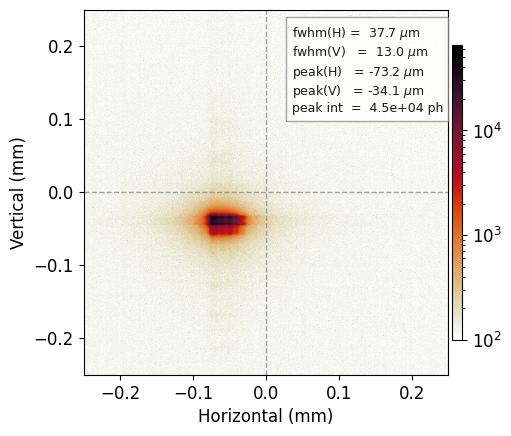

In [25]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} ")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd = dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)


plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hists[0].hh,
    hists[0].vv,
    hists[0].data_2D.T[::-1],
    cmap=m2,
    norm=mpl.colors.LogNorm(100, max_count),
    rasterized=True,
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")

text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
plt.savefig(f"{out_dir}/initial.svg", bbox_inches="tight", dpi=600)
plt.show()

In [26]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [27]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[147, 133]
79 [0.00045981565522817996, 0.0014334106393386306]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3905670010735646, 'h_fwhm': 0.01885873089393364, 'h_centroid': 0.0005517121010972792, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.45766873625762505, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.0057594896642604865, 'v_peak': -0.00032512700273549627, 'integral_intensity': 284.9587837744583, 'peak_intensity': 65045.875, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.01974591053691665


Trial number 79
Trial values: peak_distance 4.598e-04 fwhm 1.433e-03
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3905670010735646, 'h_fwhm': 0.01885873089393364, 'h_centroid': 0.0005517121010972792, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.45766873625762505, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.0057594896642604865, 'v_peak': -0.00032512700273549627, 'integral_intensity': 284.9587837744583, 'peak_intensity': 65045.875, 'gaussian_fit': {}}}
Params:
{'hb_1': -19.0, 'hb_2': -9.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.013999999999999999, 'vb_bender': -11.0, 'vb_pitch': 2.0000000000000052e-05, 'vb_trans': 0.0299}


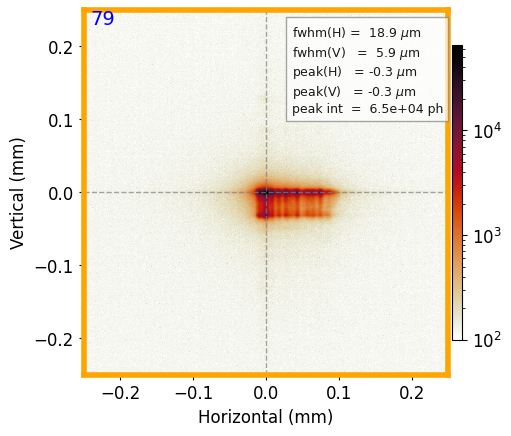

Trial number 98
Trial values: peak_distance 6.583e-03 fwhm 2.584e-04
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3906831300399076, 'h_fwhm': 0.018208429828625583, 'h_centroid': 0.0005740670810941984, 'h_peak': 0.0035766558591939883, 'v_sigma': 0.45780228752575697, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.006148491649214716, 'v_peak': -0.0055271590465025494, 'integral_intensity': 285.0382951500322, 'peak_intensity': 64420.555, 'gaussian_fit': {}}}
Params:
{'hb_1': -20.0, 'hb_2': -7.0, 'hb_pitch': -0.0006000000000000001, 'hb_trans': -0.015299999999999998, 'vb_bender': -12.0, 'vb_pitch': 0.00018000000000000004, 'vb_trans': 0.014100000000000001}


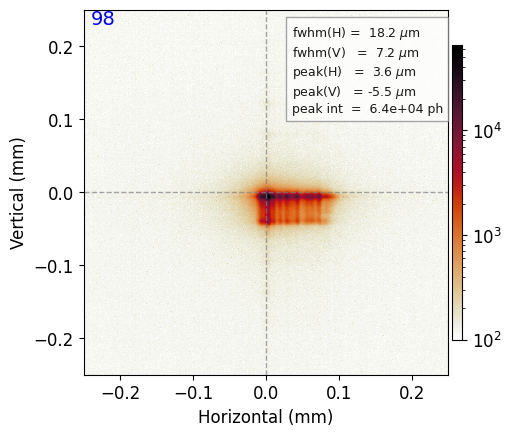

In [28]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)

    dwd = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)

    print('Params:')
    print(t.params)

    plt.figure(figsize=[5, 5], constrained_layout=True)
    plt.pcolormesh(
        hists[t.number].hh,
        hists[t.number].vv,
        hists[t.number].data_2D.T[::-1],
        cmap=m2,
        norm=mpl.colors.LogNorm(100, max_count),
        rasterized=True,
    )
    plt.xlim(-0.25, 0.25)
    plt.ylim(-0.25, 0.25)
    plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
    plt.xlabel("Horizontal (mm)")
    plt.ylabel("Vertical (mm)")
    # plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect("equal")

    text = (
        rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        rf"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph"
    )
    # ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
    ax.text(
        0.035,
        0.11,
        text,
        color="black",
        alpha=0.9,
        fontsize=9,
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7),
    )
    plt.text(-0.24, 0.23, t.number, fontsize=14, color="blue")
    plt.savefig(f"{out_dir}/pareto_{t.number}.svg", bbox_inches="tight", dpi=600)
    if t.number == nash_trial.number:
        for axis in ["top", "bottom", "left", "right"]:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color("orange")
    plt.show()

In [25]:
study.best_trials[0].values

[0.00045981565522817996, 0.0014334106393386306]

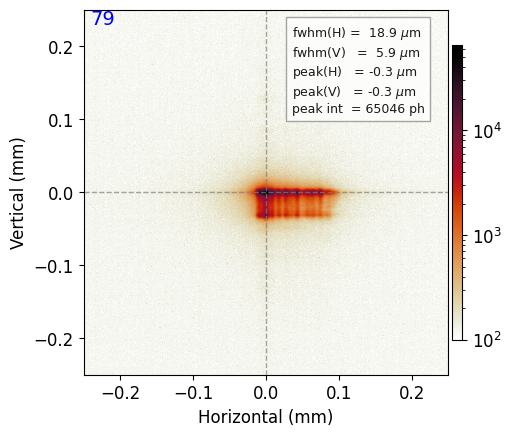

In [26]:
tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5, 5], constrained_layout=True)
plt.pcolormesh(
    hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=m2, norm=mpl.colors.LogNorm(100, max_count), rasterized=True
)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)
plt.axhline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.axvline(0, color="gray", ls="--", linewidth=1, alpha=0.7)
plt.xlabel("Horizontal (mm)")
plt.ylabel("Vertical (mm)")
# plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect("equal")


text = (
    rf"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
    rf"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
    rf"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph"
)
ax.text(
    0.035, 0.11, text, color="black", alpha=0.9, fontsize=9, bbox=dict(facecolor="white", edgecolor="gray", alpha=0.7)
)
plt.text(-0.24, 0.23, tnum, fontsize=14, color="blue")
plt.savefig(f"{out_dir}/pareto_hh.svg", bbox_inches="tight", dpi=600)
plt.show()

In [27]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ["peak_distance", "fwhm"])

In [28]:
pareto_df

,number,peak_distance,fwhm,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
79,79,0.000460,0.001433,-0.000325,-0.000325,0.018859,0.005852,65045.875000
98,98,0.006583,0.000258,0.003577,-0.005527,0.018208,0.007153,64420.554688


In [29]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]

In [30]:
c2

[98]

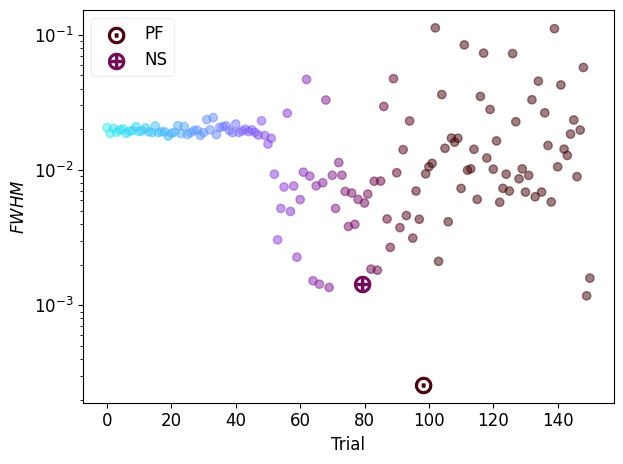

In [31]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values


plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$FWHM$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

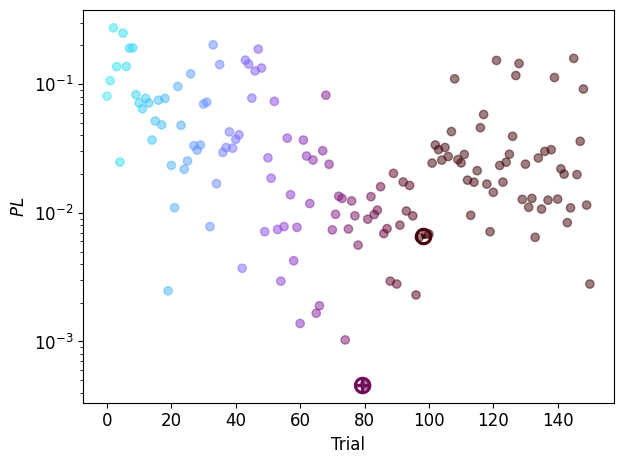

In [32]:
# Plotting the optimization histories
# optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
# plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.gem_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, 100))
plt.scatter(x[c2], y[c2], c=c2, cmap=cmm.gem_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, 100), label="PF")
plt.scatter(
    x[c1], y[c1], c=c1, cmap=cmm.gem_r, marker=r"$\oplus$", s=175, norm=mpl.colors.Normalize(0, 100), label="NS"
)

plt.xlabel("Trial")
plt.ylabel("$PL$")
plt.yscale("log")
# for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
# plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
# plt.axvline(nash_trial.number, color='orange', label='NS')
plt.tight_layout()
plt.show()

In [33]:
ntrials = len(study.trials)

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_41298/4034927181.py:36: MatplotlibDeprecationWarning: The execute_constrained_layout function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.get_layout_engine().execute() instead.
  fig.execute_constrained_layout()


4.461371181393227 4.352882222222223


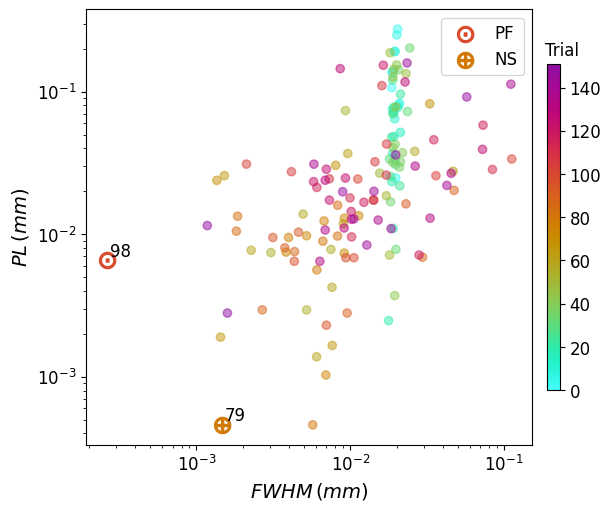

In [34]:
x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6, 5], constrained_layout=True)
plt.scatter(x[c3], y[c3], c=c3, cmap=cmm.tropical_r, marker="o", alpha=0.5, norm=mpl.colors.Normalize(0, ntrials))
plt.scatter(
    x[c2], y[c2], c=c2, cmap=cmm.tropical_r, marker=r"$\odot$", s=175, norm=mpl.colors.Normalize(0, ntrials), label="PF"
)
plt.scatter(
    x[c1],
    y[c1],
    c=c1,
    cmap=cmm.tropical_r,
    marker=r"$\oplus$",
    s=175,
    norm=mpl.colors.Normalize(0, ntrials),
    label="NS",
)

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords="offset points")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$FWHM\,(mm)$", fontsize=14)
plt.ylabel("$PL\,(mm)$", fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location="right")
# cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 155.0, "Trial")
# cbar.ax.set_xlabel('Trial')#, fontsize=14)

# plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc="best")
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f"{out_dir}/pareto_fwhm_pl.svg", bbox_inches="tight", dpi=600)
plt.show()

### Combining the figures into one

In [35]:
from  matplotlib import gridspec

In [36]:
ground = {
    "FWHM": opt_common._get_fwhm_from_dw(ref_dw),
    "PL": opt_common._get_peak_distance_from_dw(ref_dw),
    "NLPI": -np.log(opt_common._get_peak_intensity_from_dw(ref_dw)),
}

In [105]:
props = apu.AnalyzedProps(study, nash_trial, max_count=max_count, min_count=200, xylim=0.25, photon_count_str="3.1e")

In [106]:
if 'FWHM' in apu.PARETO_PLOT_ORDER:
    del apu.PARETO_PLOT_ORDER['FWHM']
apu.PARETO_PLOT_ORDER['FWHM_REF'] = 0

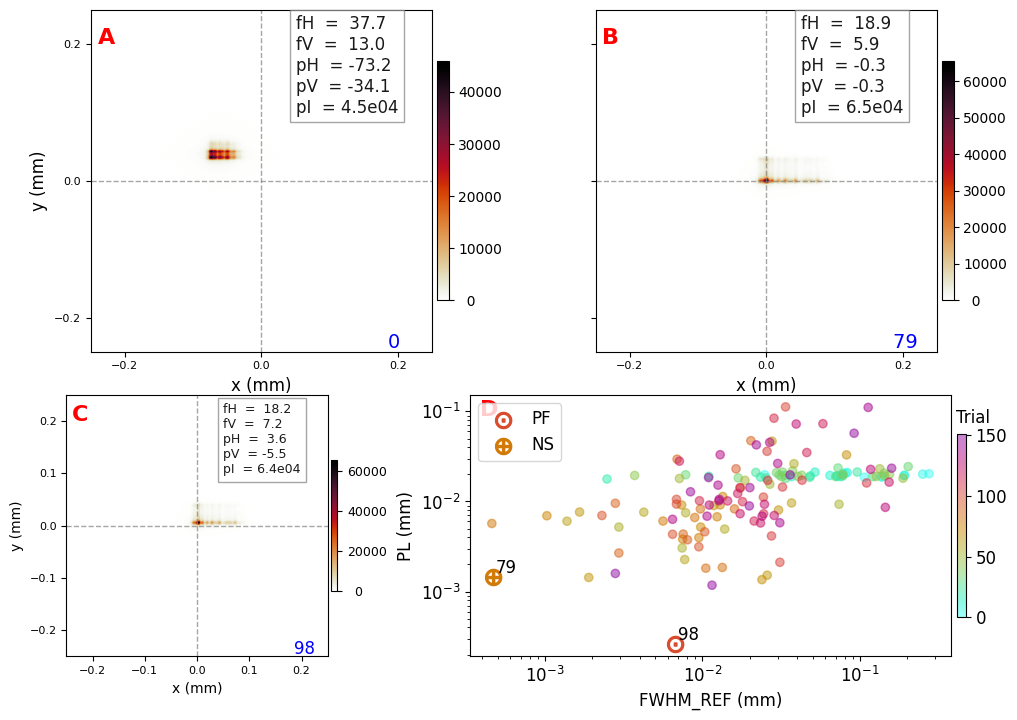

In [114]:
fig = plt.figure(figsize=[10, 7], layout="constrained")
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=[0.55, 0.45])

gss0 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])

axs0 = gss0.subplots(sharex=True, sharey=True)


#cmesh, sublabel = apu.plot_hist_2d(props, axs0[0], ref_hist, ylabel=True)
#apu.add_text_to_hist(props, axs0[0], ref_dw)


cmesh0, sublabel = apu.plot_hist_2d(props, axs0[0], hists[0], study_num=0, sublabel='A', ylabel=True)
apu.add_text_to_hist(props, axs0[0], study.trials[0].user_attrs["dw"], fontsize=12)

cmesh1, sublabel = apu.plot_hist_2d(props, axs0[1], hists[nash_trial.number], study_num=nash_trial.number, sublabel=sublabel)
apu.add_text_to_hist(props, axs0[1], study.trials[nash_trial.number].user_attrs["dw"], fontsize=12)
# _, sublabel = apu.

for ix, cmesh in enumerate([cmesh0, cmesh1]):
    cbar = fig.colorbar(cmesh, ax=axs0[ix], pad=0.01, shrink=0.7, format='%3.0f')
    cbar.ax.tick_params(labelsize=10)
    axs0[ix].locator_params(nbins=4)

gss1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1], width_ratios=[0.4, 0.6])
axs1 = gss1.subplots()

# middle row
_trials = [t for t in study.best_trials if t.number != nash_trial.number]
if len(_trials) != 1:
    raise
cmesh, sublabel = apu.plot_hist_2d(
    props,
    axs1[0],
    hists[t.number],
    study_num=t.number,
    sublabel=sublabel,
    ylabel=True,
    labelfontsize=10,
    study_num_kwargs={"size": 12},
)
cbar = fig.colorbar(cmesh, ax=axs1[0], pad=0.01, shrink=0.5, format='%3.0f')
cbar.ax.tick_params(labelsize=9)
#axs1[0].locator_params(nbins=4)

apu.add_text_to_hist(props, axs1[0], dw=t.user_attrs["dw"])  # , fontsize=7.5, x=0.55,y=0.6)


cscatter, sublabel = apu.plot_pareto_2d(
    props, axs1[1], "FWHM_REF", "PL", fontsize=12, sublabel=sublabel, annotate=True, legend=True
)
cbar = plt.colorbar(cscatter, ax=axs1[1], pad=0.01, shrink=0.7, location="right")
cbar.ax.text(-0.1, 160.0, "Trial")

fig.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0.01, wspace=0.02)
plt.savefig(f"{out_dir}/fig_combined.pdf", bbox_inches="tight", dpi=600)
plt.show()

In [166]:
study.trials[98].user_attrs['dw'].__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3906831300399076,
  'h_fwhm': 0.018208429828625583,
  'h_centroid': 0.0005740670810941984,
  'h_peak': 0.0035766558591939883,
  'v_sigma': 0.45780228752575697,
  'v_fwhm': 0.007152794060180101,
  'v_centroid': 0.006148491649214716,
  'v_peak': -0.0055271590465025494,
  'integral_intensity': 285.0382951500322,
  'peak_intensity': 64420.555,
  'gaussian_fit': {}}}

In [161]:
hists[98].data_2D.max()

65535.0

In [152]:
mask = (hists[98].data_2D == 65535)

In [154]:
np.nonzero(mask)

(array([1085]), array([1288]))

In [155]:
hists[98].data_2D[np.nonzero(mask)]

array([65535.], dtype=float32)

In [156]:
hm, vm = np.meshgrid(hists[98].hh, hists[98].vv, indexing='ij')

In [157]:
hm[np.nonzero(mask)]

array([0.00357666])

In [151]:
vm[np.nonzero(mask)]

array([ 0.00032513, -0.00032513,  0.00032513, -0.00032513,  0.00032513,
        0.00097538,  0.00162564, -0.00032513,  0.00032513,  0.00097538])

In [149]:
hm.shape, hists[79].data_2D.shape

((2160, 2560), (2160, 2560))

(-0.25, 0.25)

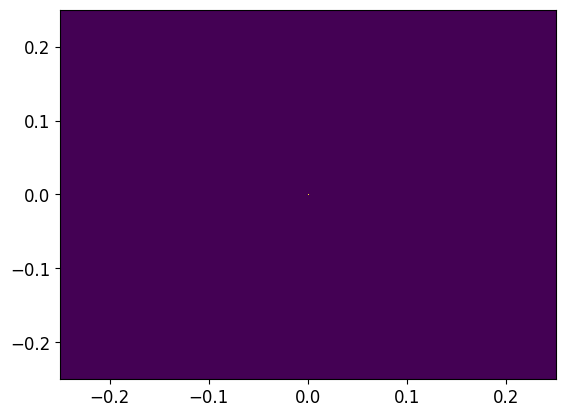

In [131]:
plt.pcolormesh(hists[79].hh, hists[79].vv, mask.T)
plt.xlim(-0.25, 0.25)
plt.ylim(-0.25, 0.25)

In [167]:
cp = analysis.CalculationParameters(use_denoised=False, nbins_h=hist.hh.size, nbins_v=hist.vv.size)

In [173]:
cp

CalculationParameters(execution_mode=0, implementor=0, xrange=None, yrange=None, nbins_h=2160, nbins_v=2560, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=None, add_noise=False, noise=None, percentage_fluctuation=10.0, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=False, every_n_images=5, rng=Generator(PCG64) at 0x7FE7E9854120)

In [185]:
hist2, dw2 = analysis.recalculate_info(cp, hists[98])

Max is 65535.0


In [192]:
65535 * 0.96

62913.6

In [193]:
dw2.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3906831300399076,
  'h_fwhm': 0.018208429828625583,
  'h_centroid': 0.0005740670810941984,
  'h_peak': 0.0035766558591939883,
  'v_sigma': 0.45780228752575697,
  'v_fwhm': 0.007152794060180101,
  'v_centroid': 0.006148491649214716,
  'v_peak': -0.0055271590465025494,
  'integral_intensity': 285.0382951500322,
  'peak_intensity': 64420.555,
  'gaussian_fit': {}}}

In [175]:
from scipy.ndimage import median_filter

In [187]:
median_filter(hists[98].data_2D, size=3).max() * 0.95

61645.5

In [170]:
dw2.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3906831300399076,
  'h_fwhm': 0.018208429828625583,
  'h_centroid': 0.0005740670810941984,
  'h_peak': 0.0035766558591939883,
  'v_sigma': 0.45780228752575697,
  'v_fwhm': 0.007152794060180101,
  'v_centroid': 0.006148491649214716,
  'v_peak': -0.0055271590465025494,
  'integral_intensity': 285.0382951500322,
  'peak_intensity': 64420.555,
  'gaussian_fit': {}}}